In [9]:
import sys
import pandas as pd
import numpy as np
import torch

from transformers import AutoTokenizer

sys.path.append("../")
from src.log import myLogger
from src.repository.data_repository import DataRepository
from src.checkpoint.checkpoint import Checkpoint
from src.metrics.jaccard import jaccard

from matplotlib import pyplot as plt

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 600)

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# !pip install googletrans==4.0.0-rc1

In [66]:
# from googletrans import Translator
# 
# translator = Translator()

In [74]:
train_df = pd.read_csv("../data/origin/train.csv")
train_df

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil
...,...,...,...,...,...,...
1109,26f356026,स्वामी निगमानन्द परमहंस (18 अगस्त 1880 - 29 नव...,स्वामी निगमानन्द परमहंस के तन्त्र गुरु कौन थे?,बामाक्षेपा,2691,hindi
1110,31179f1bb,भरत मुनि ने नाट्यशास्त्र नामक प्रसिद्ध ग्रन्थ ...,नित्यशास्त्र किसने लिखा है?,भरत मुनि,0,hindi
1111,0d35dc007,अग्नि पंचम (अग्नि-५) भारत की अन्तरमहाद्वीपीय ब...,अग्नि पंचम(५) मिसाइल की लम्बाई कितने मीटर है?,17,155,hindi
1112,7f997884d,"जलाल उद्दीन मोहम्मद अकबर () (१५ अक्तूबर, १५४२-...",मुगल सम्राट अकबर की मृत्यु किस वर्ष में हुई थी?,"२७ अक्तूबर, १६०५",46,hindi


<AxesSubplot:>

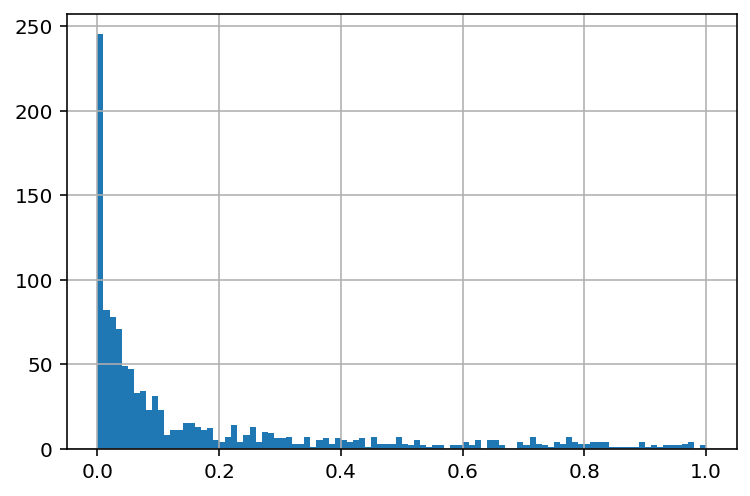

In [78]:
(train_df.answer_start / train_df.context.apply(lambda context: len(context))).hist(bins=np.arange(0, 1.01, 0.01))

In [82]:
train_df[train_df.answer_text.apply(lambda text: text.endswith("."))]

,id,context,question,answer_text,answer_start,language
288,0600263a3,மதுரை (ஆங்கிலம்:\nMadurai) இந்தியாவின் தமிழ்நா...,மதுரை மாவட்டத்தின் பரப்பளவு என்ன?,147.99 கி.மீ.,3175,tamil
649,71ffb15bf,सीवी रमन (तमिल: சந்திரசேகர வெங்கட ராமன்) (७ नव...,चंद्रशेखर वेंकट रमन के पिता कौन थे?,चन्द्रशेखर अय्यर एस. पी. जी.,529,hindi
773,d16e80019,जैसलमेर भारतीय राज्य राजस्थान का एक जिला है।\n...,जैसलमेर का क्षेत्रफल कितना है?,38401 वर्ग कि.मी.,86,hindi
777,dd3b3e47d,रोमन साम्राज्य (27 ई.पू. –- 476 (पश्चिम); 1453...,रोमन साम्राज्य को किस साल में स्थापित किया गया...,27 ई.पू.,16,hindi
805,28c563a25,"प्रदीपक गैसों में पहली गैस ""कोयला गैस"" थी। कोय...",गैस के लिये कोयले का कार्बनीकरण अधिकतम कितने ड...,"1,500 सें.",1296,hindi
876,4a92c37c2,भारतीय नौसेना(English: Indian Navy) भारतीय सेन...,भारतीय नौसेना का गठन कब हुआ?,1613 ई.,637,hindi
902,9632519cb,गुर्जर प्रतिहार वंश या प्रतिहार वंश मध्यकाल के...,गुर्जर प्रतिहार वंश का अंत किस साल में हुआ था?,१०३६ ई.,7332,hindi
921,637af0145,अर्बेला का संग्राम या गौगेमेला का युद्ध सिकंदर...,गौगेमेला का युद्ध किस वर्ष में हुआ था?,331 ई.पू.,173,hindi
925,85df64d99,सेराक्यूस के आर्किमिडीज़ (यूनानी:Ἀρχιμήδης; 28...,आर्किमिडीज़ का जन्म कब हुआ था?,287 ई.पू.,44,hindi
958,54b8087db,सीवी रमन (तमिल: சந்திரசேகர வெங்கட ராமன்) (७ नव...,चंद्रशेखर वेंकट रमन को भारत रत्न पुरस्कार कब म...,१९५४ ई.,281,hindi


In [4]:
logger = myLogger("../logs/temp.log", exp_id="e000", wdb_prj_id="temp", exp_config=None, use_wdb=False) 
dr = DataRepository(logger=logger, local_root_path="..")

2021-11-03 15:42:48,041 log.py               31   [INFO] [__init__] skip wandb init 


## e016 の 1st fold で error analysis してみる

In [22]:
e016_preprocessed_df = dr.load_preprocessed_df(
    dataset_name="train",
    class_name="BaselineKernelPreprocessorV1",
    tokenizer_name="XLMRobertaTokenizerFast",
    max_length=384,
    pad_on_right=True,
    stride=128,
    use_language_as_question=False,
)

2021-11-03 15:52:47,763 data_repository.py   230  [INFO] [load_preprocessed_df] loading data/preprocessed/train_BaselineKernelPreprocessorV1_XLMRobertaTokenizerFast_384_True_128_False.pkl ... 
2021-11-03 15:52:50,813 data_repository.py   237  [INFO] [load_preprocessed_df] done. 


In [83]:
best_checkpoints = dr.best_checkpoint_filepaths("e016")
print(best_checkpoints)
# checkpoint = dr.load_checkpoint_from_filepath(filepath_from_root=best_checkpoints[0], load_from_gcs=True, rm_local_after_load=True) 
checkpoint = dr.load_checkpoint_from_filepath(filepath_from_root=best_checkpoints[1], load_from_gcs=True, rm_local_after_load=True) 
dir(checkpoint)

2021-11-03 17:46:46,442 repository.py        167  [INFO] [__download_from_gcs] downloading data/checkpoint/e016/best_checkpoint/1_3_0.8070_0.6914.pkl from gs://kaggle-chaii-2021/../data/checkpoint/e016/best_checkpoint/1_3_0.8070_0.6914.pkl 


['data/checkpoint/e016/best_checkpoint/0_2_0.7958_0.6980.pkl', 'data/checkpoint/e016/best_checkpoint/1_3_0.8070_0.6914.pkl', 'data/checkpoint/e016/best_checkpoint/2_3_0.9464_0.6811.pkl', 'data/checkpoint/e016/best_checkpoint/3_1_0.7617_0.6812.pkl', 'data/checkpoint/e016/best_checkpoint/4_1_0.7695_0.7006.pkl']


2021-11-03 17:47:39,236 repository.py        176  [INFO] [__download_from_gcs] download done. 


['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'epoch',
 'exp_id',
 'extend_str_list_val_info',
 'extend_tensor_val_info',
 'fold',
 'model_state_dict',
 'non_filled_mambers',
 'optimizer_state_dict',
 'scheduler_state_dict',
 'set_model',
 'set_optimizer',
 'set_scheduler',
 'val_end_logits',
 'val_ids',
 'val_jaccard',
 'val_loss',
 'val_pospro_answer_preds',
 'val_pospro_answer_texts',
 'val_pospro_ids',
 'val_segmentation_logits',
 'val_start_logits']

In [84]:
ids = checkpoint.val_pospro_ids
answer_preds = checkpoint.val_pospro_answer_preds
answer_texts = checkpoint.val_pospro_answer_texts
jaccards = [jaccard(answer_pred, answer_text) for answer_pred, answer_text in zip(answer_preds, answer_texts)]

In [85]:
from time import sleep

fold_df = pd.DataFrame()
fold_df["id"] = ids
fold_df["answer_pred"] = answer_preds
fold_df["answer_text"] = answer_texts
fold_df["jaccard"] = jaccards

fold_df = fold_df.merge(e016_preprocessed_df[["id", "language"]].drop_duplicates(), on="id", how="left")
# fold_df = fold_df.merge(e016_preprocessed_df[["id", "language", "question"]].drop_duplicates(), on="id", how="left")
# fold_df["en_question"] = fold_df.apply(lambda row: translator.translate(row["question"], src=row["language"], dest="en"), axis=1)
# fold_df["en_answer_text"] = fold_df.apply(lambda row:  translator.translate(row["answer_text"], src=row["language"], dest="en"), axis=1)
# fold_df["en_answer_pred"] = fold_df.apply(lambda row: translator.translate(row["answer_pred"], src=row["language"], dest="en"), axis=1)
# fold_df = fold_df[["id", "jaccard", "en_question", "en_answer_text", "en_answer_pred", "answer_text", "answer_pred"]]

In [86]:
# . で終わる場合って消してよいの？どうなの？ ex. id 2af249652 →　数字 + . の場合は消して良さそう
# 大文字小文字問題 ex. a2690fe4c の इस्तानबुल vs इस्तांबुल = istanbul vs Istanbul
# 
fold_df.sort_values("jaccard")

,id,answer_pred,answer_text,jaccard,language
0,004938454,பதினெட்டாம் நூற்றாண்டின் இறுதிப் பத்தாண்டுகளில்,1990,0.000000,tamil
124,9031feef1,महाराष्ट्र के अश्मक,कुसुमपुर,0.000000,hindi
121,89a46bb80,"75,266",194,0.000000,hindi
120,89561de47,சனி,வியாழன்,0.000000,tamil
117,87c08ced4,सुकेंद्रिक' या 'युकेरियोटी,युकेरियोटी,0.000000,hindi
112,83a2621f5,13 சனவரி 2014,2011,0.000000,tamil
102,77a263d51,என்ரி பெக்கரல்,ஹென்றி பெக்கொரெலு,0.000000,tamil
92,67b7f2604,9.4,12-15,0.000000,tamil
89,66efdba8c,குயத் தொழில்,குயவர்,0.000000,tamil
86,63f0f1e17,திரையிசை,இந்தியத் திரைப்பட இசைப் பாடகர்,0.000000,tamil


In [24]:
context = e016_preprocessed_df.query("id == 'a2690fe4c'").iloc[0]["context"]
context

'क़ुस्तुंतुनिया या कांस्टैंटिनोपुल (यूनानी: Κωνσταντινούπολις कोन्स्तान्तिनोउपोलिस या Κωνσταντινούπολη कोन्स्तान्तिनोउपोली; लातीनी: Constantinopolis कोन्स्तान्तिनोपोलिस; उस्मानी तुर्कीयाई: قسطنطینية, Ḳosṭanṭīnīye कोस्तान्तिनिये\u200e), बोस्पोरुस जलसन्धि और मारमरा सागर के संगम पर स्थित एक ऐतिहासिक शहर है, जो रोमन, बाइज़ेंटाइन, और उस्मानी साम्राज्य की राजधानी थी। 324 ई. में प्राचीन बाइज़ेंटाइन सम्राट कोन्स्टान्टिन प्रथम द्वारा रोमन साम्राज्य की नई राजधानी के रूप में इसे पुनर्निर्मित किया गया, जिसके बाद इन्हीं के नाम पर इसे नामित किया गया।\nपरिचय\nइस शहर की स्थापना रोमन सम्राट कोन्स्टान्टिन महान ने 328 ई. में प्राचीन शहर बाइज़ेंटाइन को विस्तृत रूप देकर की थी। नवीन रोमन साम्राज्य की राजधानी के रूप में इसका आरंभ 11 मई 330 ई. को हुआ था। यह शहर भी रोम के समान ही सात पहाड़ियों के बीच एक त्रिभुजाकार पहाड़ी प्रायद्वीप पर स्थित है और पश्चिमी भाग को छोड़कर लगभग सभी ओर जल से घिरा हुआ है। रूम सागर और काला सागर के मध्य स्थित बृहत् जलमार्ग पर होने के कारण इस शहर की स्थिति बड़ी महत्वपूर्ण रही है। इसके 

In [27]:
set("इस्तांबुल") & set("इस्तानबुल")

{'इ', 'त', 'ब', 'ल', 'स', 'ा', 'ु', '्'}

In [28]:
set("इस्तांबुल") - set("इस्तानबुल")

{'ं'}

In [29]:
 set("इस्तानबुल") - set("इस्तांबुल")

{'न'}

In [30]:
context = e016_preprocessed_df.query("id == '761874dd6'").iloc[0]["context"]
context

'मुफ़्ती मोहम्मद सईद (12 जनवरी 1936 - 7 जनवरी 2016) भारत के जम्मू और कश्मीर राज्य के मुख्यमंत्री थे। वे जम्मू और कश्मीर पीपुल्स डेमोक्रेटिक पार्टी के अध्यक्ष थे। वे भारत के गृह मंत्री भी रहे।[1] इस पद पर आसीन होने वाले वे पहले मुस्लिम भारतीय थे। ०७ जनवरी २०१६ को दिल्ली में उनका निधन हुआ।[2]\n२०१४ के चुनावों में वे अनंतनाग विधानसभा निर्वाचन क्षेत्र से कांग्रेस के उम्मीदवार हिलाल अहमद शाह को 6028 वोटों के अंतर से हराकर विधायक निर्वाचित हुए।[3] साल १९८९ में इनकी बेटी रूबैया सईद का अपहरण कर लिया गया था। रुबैया के बदले में आतंकवादियों ने अपने पांच साथियों को मुक्त करवा दिया था। इस घटना का विरोध जम्मू कश्मीर के तत्कालीन मुख्यमंत्री फारूक अब्दुल्ला ने किया था। भारत के गृहमंत्री रहते हुए भी २४ दिसम्बर १९९९ को इन्डियन एयरलाइंस का विमान अपहृत कर लिया गया, परिणाम स्वरूप अजहर मसूद एवं अन्य दो आतंकियों को रिहा करना पड़ा।[4]\nआरंभिक जीवन\nमुफ़्ती का जन्म 12 जनवरी, 1936 में जम्मू कश्मीर के अनंतनाग जिले में बिजबेहरा नामक स्थान पर हुआ था। उन्होने अलीगढ़ मुस्लिम विश्वविद्यालय से अरब इतिहास की परास्नातक 

In [73]:
print(e016_preprocessed_df.query("id == 'dab6fa1cf'").iloc[0]["context"])

எத்தனால் (Ethanol) என்பது எரிநறா அல்லது வெறியம் என்னும் வகையைச் சார்ந்த ஒரு வேதிச் சேர்மம் ஆகும். இது எரியக்கூடிய தன்மையுடையதும் நிறமற்றதும் ஆகும். மதுபானங்களில் பொதுவாகக் கலந்திருக்கும் இந்த வெறியம் ஆதி காலத்தில் இருந்து ஒரு போதைப் பொருளாக அறியப்பட்ட ஒன்று ஆகும். ஈசுட்டு என்ற நொதியைப் பயன்படுத்தி சர்க்கரையை நொதிக்கச் செய்து எத்தனால் தயாரிப்பது மனிதகுலம் அறிந்த கரிம வேதிவினைகளுள் முதன்மையானவற்றுள் ஒன்று என்றும் நம்பப்படுகிறது. பெட்ரோ வேதியியல் செயல்முறையிலும் எத்தனாலை தயாரிக்க இயலும். ஆல்ககால், எத்தில் ஆல்ககால், குடிக்கும் ஆல்ககால் என்ற பல பெயர்களாலும் இது அழைக்கப்படுகிறது.
நிறமற்ற நீர்மமான இச்சேர்மம் தீப்பற்றி எரியக்கூடியதாகவும், எளிதில் ஆவியாகக் கூடியதாகவும், உள்ளது. எத்தில் ஆல்ககாலின் வேதியியல் வாய்ப்பாடு C2H6O ஆகும். இவ்வாய்ப்பாட்டை CH3-CH2-OH அல்லது C2H5-OH என்றும் எழுதலாம். அதாவது எத்திலீனில் (C2H6) உள்ள ஓர் ஐதரசனுக்கு மாற்றீடாக ஒரு ஐதராக்சைல் குழு (-OH) உள்ளது. இப்படி எழுதுவதால் மெத்தில் குழுவில் (CH3-) உள்ள கரிமம் மெத்திலீன் குழுவில் (-CH2-) உள்ள கரிமத்துடன் இணைந்துள்ளது என்றும

In [70]:
e016_preprocessed_df.query("id == '15e538650'").iloc[0]["question"]

'लेम्बोर्गिनी इतालियन कंपनी द्वारा अब बनायीं गयी?'